In [3]:
import pygimli as pg
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

from influxdb_client import InfluxDBClient
import os
import matplotlib.pyplot as plt
from datetime import datetime 
import pandas as pd
import os

from Hilfsfunktionen import read
from Hilfsfunktionen import resistivity_area
from Hilfsfunktionen import Baumstandorte
from Hilfsfunktionen import extract_sensor_data
from Hilfsfunktionen import extract_sensor_data_continuous
from Hilfsfunktionen import Feuchtesensoren


In [4]:
# Read raw data
file = "all_timesteps.ohm"
base_dir = Path("filtered_data")
data = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "all_timesteps.ohm" 
        if datei_pfad.exists():
            daten_objekt = pg.load(str(datei_pfad))
            data.append([unterordner.name, daten_objekt])
            print(f"Load data: {datei_pfad}")
# Read inversion results
mesh = pg.load('./Result_all_timesteps/mesh/mesh.bms')
array = np.load('./Result_all_timesteps/FTL/result_scalef0.7_ab1907.npy')
array_ref = np.load('./Result_all_timesteps/Ref/result_lam20_100_alle_mitTcorr.npy')
array_diff = np.load('./Result_all_timesteps/Diff/result_lam20_100_alle_mitTcorr.npy')

Load data: filtered_data\230719\all_timesteps.ohm
Load data: filtered_data\230816\all_timesteps.ohm
Load data: filtered_data\231025\all_timesteps.ohm
Load data: filtered_data\231122\all_timesteps.ohm
Load data: filtered_data\240124\all_timesteps.ohm
Load data: filtered_data\240214\all_timesteps.ohm
Load data: filtered_data\240315\all_timesteps.ohm
Load data: filtered_data\240417\all_timesteps.ohm
Load data: filtered_data\240605\all_timesteps.ohm
Load data: filtered_data\240610\all_timesteps.ohm
Load data: filtered_data\240704\all_timesteps.ohm
Load data: filtered_data\240725\all_timesteps.ohm
Load data: filtered_data\240821\all_timesteps.ohm
Load data: filtered_data\241001\all_timesteps.ohm
Load data: filtered_data\241030\all_timesteps.ohm


(-0.15, -0.45)

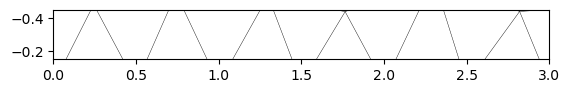

In [6]:
# Mesh an bestimmter Stelle anschauen
pg.show(mesh, xlim= 1)
plt.xlim([0,3])
plt.ylim([-0.15,-0.45])

In [9]:
# Duchschnitts resistivity Werte in den Bereichen +- 0,5 m um Feuchtesensoren FTL
tiefen = [[0, -0.3],[-0.05, -0.55], [-0.25, -0.75], [-0.75, -1.25], [-1.75, -2.25]]
df_sens = pd.DataFrame(columns=['Timestep','Sensor', 'Tiefe', 'res'])
s = 38
for sens in [s,s,s,s,s]:#Feuchtesensoren(Ort=ort): # ein Baum
    for tiefe in tiefen: # eine Tiefe
         #submesh hinzufügen 
        resistivity_einzeln = resistivity_area(mesh=mesh, mod=array, x_min = sens - 0.5, x_max = sens + 0.5,
                                               y_min = tiefe[1], y_max = tiefe[0])
        for (count, res),wen in zip(enumerate(resistivity_einzeln), data): # res ist jetzt ein Baum, eine Tiefe und ein Zeitpunkt '
            for r in res:
                df2_sens = pd.DataFrame({'Timestep': wen[0],'Sensor': sens, 'Tiefe': tiefe[0], 'res': r }, index = [0])
                df_sens = pd.concat([df_sens,df2_sens], ignore_index=True)    
new_df_sens = df_sens.groupby(['Timestep','Sensor', 'Tiefe'])['res'].mean().reset_index()

24/04/25 - 23:32:13 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:14 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:32:15 - pyGIMLi - INFO - Found 1 regions.
C:\Users\johan\AppData\Local\Temp\ipykernel_60708\1074354581.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

In [10]:
# Duchschnitts resistivity Werte in den Bereichen +- 0,5 m um Feuchtesensoren REFERENZ
tiefen = [[0, -0.3],[-0.05, -0.55], [-0.25, -0.75], [-0.75, -1.25], [-1.75, -2.25]]
df_sens_ref = pd.DataFrame(columns=['Timestep','Sensor', 'Tiefe', 'res'])
for sens in [s,s,s,s,s]: # ein Baum
    for tiefe in tiefen: # eine Tiefe
         #submesh hinzufügen 
        resistivity_einzeln = resistivity_area(mesh=mesh, mod=array_ref, x_min = sens - 0.5, x_max = sens + 0.5,
                                               y_min = tiefe[1], y_max = tiefe[0])
        for (count, res),wen in zip(enumerate(resistivity_einzeln), data): # res ist jetzt ein Baum, eine Tiefe und ein Zeitpunkt '
            for r in res:
                df2_sens_ref = pd.DataFrame({'Timestep': wen[0],'Sensor': sens, 'Tiefe': tiefe[0], 'res': r }, index = [0])
                df_sens_ref = pd.concat([df_sens_ref,df2_sens_ref], ignore_index=True)    
new_df_sens_ref = df_sens_ref.groupby(['Timestep','Sensor', 'Tiefe'])['res'].mean().reset_index()

24/04/25 - 23:33:06 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:06 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:06 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:06 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:07 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:08 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:08 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:08 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:08 - pyGIMLi - INFO - Found 1 regions.
C:\Users\johan\AppData\Local\Temp\ipykernel_60708\2118978958.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

In [11]:
# Duchschnitts resistivity Werte in den Bereichen +- 0,5 m um Feuchtesensoren DIFF
tiefen = [[0, -0.3],[-0.05, -0.55], [-0.25, -0.75], [-0.75, -1.25], [-1.75, -2.25]]
df_sens_diff = pd.DataFrame(columns=['Timestep','Sensor', 'Tiefe', 'res'])
for sens in [s,s,s,s,s]: # ein Baum
    for tiefe in tiefen: # eine Tiefe
         #submesh hinzufügen 
        resistivity_einzeln = resistivity_area(mesh=mesh, mod=array_diff, x_min = sens - 0.5, x_max = sens + 0.5,
                                               y_min = tiefe[1], y_max = tiefe[0])
        for (count, res),wen in zip(enumerate(resistivity_einzeln), data): # res ist jetzt ein Baum, eine Tiefe und ein Zeitpunkt '
            for r in res:
                df2_sens_diff = pd.DataFrame({'Timestep': wen[0],'Sensor': sens, 'Tiefe': tiefe[0], 'res': r }, index = [0])
                df_sens_diff = pd.concat([df_sens_diff,df2_sens_diff], ignore_index=True)    
new_df_sens_diff = df_sens_diff.groupby(['Timestep','Sensor', 'Tiefe'])['res'].mean().reset_index()

24/04/25 - 23:33:56 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:56 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:56 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:56 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:57 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:58 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:58 - pyGIMLi - INFO - Found 1 regions.
24/04/25 - 23:33:58 - pyGIMLi - INFO - Found 1 regions.
C:\Users\johan\AppData\Local\Temp\ipykernel_60708\2715954073.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

In [19]:
# Read soil moisture data
data_frame_TDR_list = []
for i in [15, 30, 50, 100,200]:  
    filename = f"depth_{i}.csv"
    df = pd.read_csv('./Soil_moisture_data/' +filename)
    if '_time' in df.columns:
        df['_time'] = pd.to_datetime(df['_time'])
    data_frame_TDR_list.append(df)

In [20]:
Farben= ['r', 'b', 'black']
Farben_ref = ['indianred','cornflowerblue', 'dimgray']
Farben_diff = ['tomato', 'lightsteelblue','lightgray']

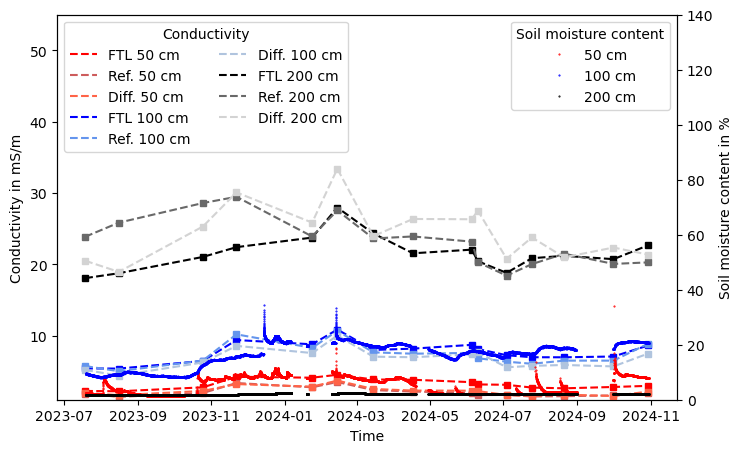

In [24]:
# Alle Feuchtesensoren in einem Graph
fig, ax = plt.subplots(figsize=(8, 5))
selected_tiefen = tiefen
selected_data_frame_TDR_list = data_frame_TDR_list
for (count, t), depth in zip(enumerate(selected_tiefen[2:5]), list_of_depth[2:5]): # tiefen
    tiefe_filter = new_df_sens[new_df_sens['Tiefe'] == t[0]]
    # Full Time Lapse Inversion
    ax.plot([datetime.strptime(date, "%y%m%d") for date in tiefe_filter['Timestep']], 
            [1000/i for i in tiefe_filter['res']], '--', label = 'FTL ' + str(int(100*abs(t[0]-0.25))) + ' cm' , color=Farben[count%len(Farben)], zorder=3)
    ax.plot(
        [datetime.strptime(date, "%y%m%d") for date in tiefe_filter['Timestep']], 
        [1000/i for i in tiefe_filter['res']], 's',color=Farben[count%len(Farben)], markersize=5, zorder=3)  

    tiefe_filter_ref = new_df_sens_ref[new_df_sens_ref['Tiefe'] == t[0]]
    tiefe_filter_diff = new_df_sens_diff[new_df_sens_diff['Tiefe'] == t[0]]
    # Reference Inversion
    ax.plot([datetime.strptime(date, "%y%m%d") for date in tiefe_filter_ref['Timestep']], 
            [1000/i for i in tiefe_filter_ref['res']], '--', label ='Ref. ' + str(int(100*abs(t[0]-0.25))) + ' cm', color=Farben_ref[count%len(Farben)], zorder=3)
    ax.plot(
        [datetime.strptime(date, "%y%m%d") for date in tiefe_filter_ref['Timestep']], 
        [1000/i for i in tiefe_filter_ref['res']], 's',color=Farben_ref[count%len(Farben)], markersize=5, zorder=3) 
    
    # Difference Inversion
    ax.plot([datetime.strptime(date, "%y%m%d") for date in tiefe_filter_diff['Timestep']], 
            [1000/i for i in tiefe_filter_diff['res']], '--', label ='Diff. ' + str(int(100*abs(t[0]-0.25))) + ' cm' , color=Farben_diff[count%len(Farben)], zorder=3)
    ax.plot(
        [datetime.strptime(date, "%y%m%d") for date in tiefe_filter_diff['Timestep']], 
        [1000/i for i in tiefe_filter_diff['res']], 's',color=Farben_diff[count%len(Farben)], markersize=5, zorder=3)    
    
ax.set_xlabel('Time')
ax.set_ylabel('Conductivity in mS/m')
ax.legend( title = 'Conductivity',loc = 'upper left', ncol = 2)
#ax.set_yscale('log')
ax.set_ylim(1,55)

ax2 = ax.twinx() 

for (count, df), depth in zip(enumerate(selected_data_frame_TDR_list[2:5]), list_of_depth[2:5]):
    ax2.plot(df['_time'], df['WaterContent_%vol'], '.', markersize= 1, color=Farben[count%len(Farben)], label = str(depth) + ' cm')
ax2.set_ylim(0,140)

ax2.set_ylabel('Soil moisture content in %')
ax2.legend(title = 'Soil moisture content',loc = 'upper right')

#plt.title('Feuchtesensoren')
plt.show()
fig.savefig('./Fig13/Comparison_of_inversion_approaches.png' , bbox_inches = 'tight', dpi=300)